# Streaming TimeSeries prediction using SPSS Flow deployed in WML

**(C) 2019 IBM - Philippe Gregoire - Ecosystem Advocacy Group Europe - Partners Technical Enablement**

## Prerequisites:
* A SPSS Flow with a Streaming Time Series node must be deployed to Watson Machine Learning
* An input file in CSV format with columns matching the deployed WML SPSS model must be present in Cloud Object Storage

## Operations
* We first load the CSV file from COS into a pandas DataFrame, `df_data`
* That dataframe is converted to an array of rows, each row itself being an array or individual values.
* We initialize the WML client with the WML credentials where that model is deployed.
* The array of timeseries values is fed into a WML prediction call
* The predictions are returned in JSON-formatted text
* We convert the text to JSON (Python dictionary) and then back to a Results DataFrame
* The predictions DataFrame is then stored in a new file in COS

## Notes
* Here we assume that the input CSV file has been created in COS from its DB2 data source tables, using a Data refinery flow that has joined the two
* We could also connect directly to the DB2 tables and build the dataframe from there rather than going through COS

In [1]:
# the below credentials code has been inserted from the data asset drawer on the right of Watson Studio notebook

# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
cos_credentials = {
    'IAM_SERVICE_ID': 'iam-ServiceId-84ac513a-561e-4bcf-b512-bab546c69110',
    'IBM_API_KEY_ID': '9e3o-KlEAwlHhw7q_H0OasJdmQ5iQ2PWO65sn4rh9XIf',
    'ENDPOINT': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.bluemix.net/oidc/token',
    'BUCKET': 'watsonstudioworkshophandson2019-donotdelete-pr-cbykacgzkm1ru6',
    'FILE': 'broadband.csv'
}


In [2]:
# retrieve your wml_service_credentials_username, wml_service_credentials_password, and wml_service_credentials_url from the
# Service credentials associated with your IBM Cloud Watson Machine Learning Service instance
# @hidden_cell
wml_credentials = {
  "apikey": "vI_wmlD2pg4RF_9DHYyvn1sH0ZySH8eCVSRwUVGhgIav",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:pm-20:eu-gb:a/c7ab6a05ec1e3eb13f5e81aa302bdbd0:09418887-6f95-4443-b16d-123b2a15c937::",
  "iam_apikey_name": "auto-generated-apikey-ac2f8adb-0cbf-475e-980b-f521cc5642ed",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/c7ab6a05ec1e3eb13f5e81aa302bdbd0::serviceid:ServiceId-796dbfc6-a783-4f93-8735-ca6fe5b7a6fa",
  "instance_id": "09418887-6f95-4443-b16d-123b2a15c937",
  "password": "d7bc841e-70f5-4fa2-8a31-253a4339c4d3",
  "url": "https://eu-gb.ml.cloud.ibm.com",
  "username": "ac2f8adb-0cbf-475e-980b-f521cc5642ed"
}

In [51]:
# Setup some constants
# Name of the timestamp field/column
key_ts='DATE_'
# Number of Markets
MarketMax=85
# Name of WML model
TSModelName='Markets_Predictions'

In [4]:
# Get the data from the joined COS table object, using the credentials from above
import types
import numpy as np
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=cos_credentials['IBM_API_KEY_ID'],
    ibm_auth_endpoint=cos_credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=cos_credentials['ENDPOINT'])

body = cos.get_object(Bucket=cos_credentials['BUCKET'],Key=cos_credentials['FILE'])['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# Read the input Time Series file
df_ts = pd.read_csv(body)

In [5]:
# Adjust types, so that we can sort on timestamp
df_ts[key_ts]=pd.to_datetime(df_ts[key_ts])
# show some statistics
df_ts.dtypes.to_frame().transpose().append(df_ts.describe())

,DATE_,MONTH_,Market_1,Market_10,Market_11,Market_12,Market_13,Market_14,Market_15,Market_16,...,Market_8,Market_80,Market_81,Market_82,Market_83,Market_84,Market_85,Market_9,Total,YEAR_
0,datetime64[ns],int64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
count,NaN,60,60,60,60,60,60,60,60,60,...,60,60,60,60,60,60,60,60,60,60
mean,NaN,6.5,7786.09,15685.8,9776.5,48395.1,22741,15734.6,7472.61,7589.77,...,4974.89,5959.19,25656.9,44841.9,15899.3,11397.2,13960.7,11969.6,1.38232e+06,2001
std,NaN,3.48118,2437.92,4736.92,3188.93,27290,10256.2,4420.5,2644.31,2617.44,...,1646.25,1817.5,8644.93,18836.3,6822.99,3629.06,4605.25,5293.94,554993,1.42615
min,NaN,1,3750.18,6723.89,4233.35,11842.1,10201,6619.88,3233.94,3460.77,...,2363.48,3042.21,9860.9,14480.6,7000.21,5648.5,6818.4,5041.96,536413,1999
25%,NaN,3.75,6089.71,11845.5,6950.1,24902.8,13716.3,12496.4,5435.64,5355.28,...,3703.59,4542.68,19137.2,28605.7,10176.3,8336.38,9797.82,7661.67,900182,2000
50%,NaN,6.5,7491.76,15984.2,9683.32,42219.2,20538.2,17128.3,7027.07,7365.21,...,4713.32,5962.48,25920.3,44752.2,14251.9,11443.9,14395,10425.2,1.34187e+06,2001
75%,NaN,9.25,10180.6,20011.3,12752.9,70440.4,28886,19726.7,9427.21,9699.87,...,6450.07,7340.76,32633.5,60419.2,21381.9,14327.4,17284.3,16282.5,1.83374e+06,2002
max,NaN,12,11731.1,23030,14061.1,107286,47050.6,21597.9,12563.2,12562.3,...,7623.25,9380.13,41935.8,76629.6,29810.6,16797.9,23017.7,22930.9,2.40676e+06,2003


In [6]:
# Order by timestamp
df_ts.sort_values(key_ts,inplace=True)
# Show the data
df_ts

,Market_1,Market_2,Market_3,Market_4,Market_5,Market_6,Market_7,Market_8,Market_9,Market_10,...,Market_80,Market_81,Market_82,Market_83,Market_84,Market_85,Total,YEAR_,MONTH_,DATE_
0,3750.179792,11488.581108,11658.795443,4571.338134,2205.463753,5487.834374,6143.918612,2363.483431,5041.957905,6723.886292,...,3042.208010,9860.896324,14480.626177,7000.206110,5648.500592,6818.398467,5.364128e+05,1999,1,1999-01-01
1,3846.066274,11984.018649,12227.942408,4824.890057,2301.426550,5671.674406,6389.757679,2404.099038,5159.707716,6970.350934,...,3069.078520,10431.792233,15162.226892,7271.916925,5750.185462,6943.441941,5.587971e+05,1999,2,1999-02-01
2,3894.418165,12265.668765,12896.507548,5040.973564,2352.200626,5802.188406,6669.757684,2468.803621,5232.018706,7338.078740,...,3138.725721,11141.036381,15961.208551,7667.776557,5900.555299,7129.984845,5.820775e+05,1999,3,1999-03-01
3,4009.801974,12800.948326,13715.694537,5210.632898,2489.513496,5899.444825,6929.257517,2573.599758,5403.422185,7741.644982,...,3218.465458,11839.783548,16932.897439,7868.932197,5943.681184,7332.548143,6.053324e+05,1999,4,1999-04-01
4,4146.703036,13290.949737,14646.745863,5383.489476,2534.314453,6016.973845,7312.021798,2654.271723,5543.335502,8146.843838,...,3329.932008,12595.677343,17758.368463,8057.187104,6008.612768,7637.344367,6.300192e+05,1999,5,1999-05-01
5,4334.559128,13828.143236,15419.372989,5495.729505,2663.904815,6137.370951,7492.860913,2698.560955,5773.466675,8376.618298,...,3431.114773,13464.406432,18266.475345,8427.571264,6176.535718,7929.931449,6.546938e+05,1999,6,1999-06-01
6,4554.119797,14273.262263,16107.797469,5746.520152,2737.940684,6249.770282,7701.632070,2786.208837,5904.352691,8733.319731,...,3504.791522,14260.210383,19058.463338,8587.055702,6313.399124,8144.915569,6.788767e+05,1999,7,1999-07-01
7,4744.258115,14664.356020,16958.175520,5884.548170,2753.582676,6439.344135,7965.437231,2847.155456,6032.433559,9089.511914,...,3685.707930,15270.571189,19881.377224,8822.608984,6429.562671,8270.018476,7.029581e+05,1999,8,1999-08-01
8,4884.630434,15130.442301,17642.076841,6053.445148,2874.400661,6701.417052,8107.397173,2966.768579,6149.657530,9534.434302,...,3785.846034,15991.183156,20995.830479,8922.224202,6718.495006,8362.664453,7.276665e+05,1999,9,1999-09-01
9,5019.520503,15851.402308,18452.871680,6229.124375,2974.863483,6957.021864,8366.188266,3098.756745,6342.630957,9999.307534,...,3879.054256,16821.871443,21851.287163,9178.170578,6908.245424,8595.508647,7.524670e+05,1999,10,1999-10-01


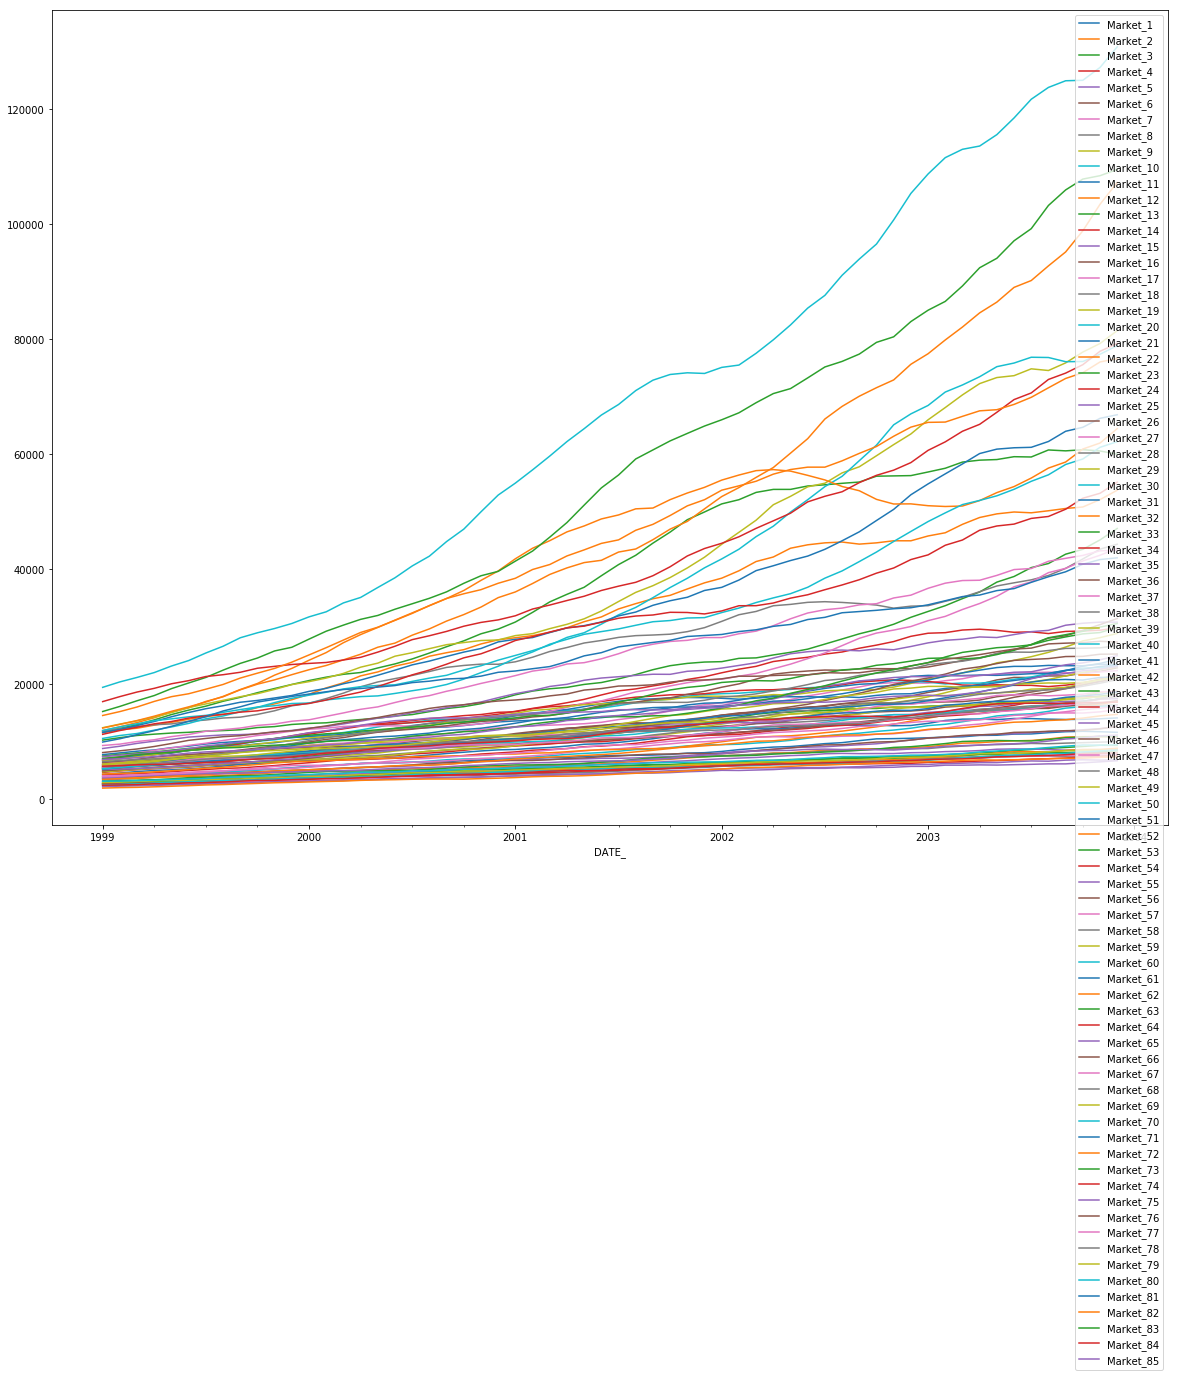

In [15]:
# plot Market_1 to market_5 after setting index to the DATE_ column
df_ts.set_index(key_ts)[['Market_{}'.format(x+1) for x in range(0,MarketMax)]].plot(figsize=(20,15));

In [58]:
# Locate the WML model
# Load WML Client API (See https://wml-api-pyclient.mybluemix.net/)
from watson_machine_learning_client import WatsonMachineLearningAPIClient

wmlClient = WatsonMachineLearningAPIClient(wml_credentials)
#wmlClient.service_instance.get_details()

# Find our model deployment
depl=[x['entity'] for x in wmlClient.deployments.get_details()['resources'] if x['entity']['published_model']['name']==TSModelName][0]
depl

{'deployable_asset': {'created_at': '2019-02-15T14:40:58.905Z',
  'description': '',
  'guid': '0a2a3985-e784-4b88-9a7c-88f746fcb79d',
  'name': 'Markets_Predictions',
  'type': 'model',
  'url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/09418887-6f95-4443-b16d-123b2a15c937/published_models/0a2a3985-e784-4b88-9a7c-88f746fcb79d'},
 'deployed_version': {'guid': '2f66af44-ea97-46c5-8077-ebeb71d57f95',
  'url': 'https://eu-gb.ml.cloud.ibm.com/v3/ml_assets/models/0a2a3985-e784-4b88-9a7c-88f746fcb79d/versions/2f66af44-ea97-46c5-8077-ebeb71d57f95'},
 'model_type': 'spss-modeler-18.1',
 'name': 'REST_Market_Predict',
 'published_model': {'created_at': '2019-02-15T14:40:58.905Z',
  'description': '',
  'guid': '0a2a3985-e784-4b88-9a7c-88f746fcb79d',
  'name': 'Markets_Predictions',
  'url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/09418887-6f95-4443-b16d-123b2a15c937/published_models/0a2a3985-e784-4b88-9a7c-88f746fcb79d'},
 'runtime_environment': 'spss-modeler-18.1',
 'scoring_ur

In [67]:
# Get the model details
model=wmlClient.repository.get_model_details(depl['published_model']['guid'])['entity']
# Create a data frame structure that matches the model's 'input_data_schema'
input_columns=[x['name'] for x in model['input_data_schema']['fields']]
df_ts=df_ts[input_columns]

In [75]:
# Extract input table as array of values suitable for WML invocation input
values_ts=[[str(e) for e in r] for r in df_ts.itertuples(index=False,name=None)]
print("predicting with {} lines as input".format(len(values_ts)))
payload_predict = {"fields": input_columns, "values": values_ts}

predicting with 60 lines as input


In [76]:
# Score using the WML API
predictions = wmlClient.deployments.score(depl['scoring_url'], payload_predict)

In [78]:
# Convert response back to dataframe
dfPredict=pd.DataFrame.from_records(predictions['values'],columns=predictions['fields'])
# Convert TS column
dfPredict[key_ts]=pd.to_datetime(dfPredict[key_ts],format="%Y-%m-%d %H:%M %p %Z")
dfPredict

,DATE_,$FutureFlag,Market_1,Market_2,Market_3,Market_4,Market_5,$TS-Market_1,$TSLCI-Market_1,$TSUCI-Market_1,...,$TSUCI-Market_3,$TSResidual-Market_3,$TS-Market_4,$TSLCI-Market_4,$TSUCI-Market_4,$TSResidual-Market_4,$TS-Market_5,$TSLCI-Market_5,$TSUCI-Market_5,$TSResidual-Market_5
0,1999-01-01,0,3750.179792,11488.581108,11658.795443,4571.338134,2205.463753,NaN,NaN,NaN,...,NaN,NaN,4890.455333,4063.503596,5837.728701,-0.063388,NaN,NaN,NaN,NaN
1,1999-02-01,0,3846.066274,11984.018649,12227.942408,4824.890057,2301.426550,NaN,NaN,NaN,...,NaN,NaN,4698.140625,4537.952946,4862.535775,0.026770,NaN,NaN,NaN,NaN
2,1999-03-01,0,3894.418165,12265.668765,12896.507548,5040.973564,2352.200626,NaN,NaN,NaN,...,13089.763974,0.005570,4892.443367,4725.635377,5063.632592,0.030056,2419.062014,2299.504685,2543.232409,-0.027713
3,1999-04-01,0,4009.801974,12800.948326,13715.694537,5210.632898,2489.513496,NaN,NaN,NaN,...,13835.930820,0.010352,5198.674335,5021.430421,5380.573449,0.002446,2417.864126,2309.770972,2529.716066,0.029460
4,1999-05-01,0,4146.703036,13290.949737,14646.745863,5383.489476,2534.314453,4223.066397,3880.202871,4588.216910,...,14801.464138,0.008362,5397.799656,5213.772090,5586.660446,-0.002506,2511.843303,2402.423010,2624.967834,0.009150
5,1999-06-01,0,4334.559128,13828.143236,15419.372989,5495.729505,2663.904815,4303.308648,4200.215739,4408.292029,...,15882.267418,-0.010746,5639.132882,5446.883229,5836.431547,-0.025610,2569.979854,2458.904630,2684.784872,0.036135
6,1999-07-01,0,4554.119797,14273.262263,16107.797469,5746.520152,2737.940684,4471.720016,4364.592532,4580.811955,...,16616.653452,-0.012276,5788.772616,5591.427424,5991.300482,-0.007177,2718.048865,2600.867099,2839.155332,0.007530
7,1999-08-01,0,4744.258115,14664.356020,16958.175520,5884.548170,2753.582676,4769.108500,4654.856581,4885.455519,...,17236.106875,0.002569,6000.499629,5795.942794,6210.428359,-0.019364,2720.139421,2602.961738,2841.238409,0.012458
8,1999-09-01,0,4884.630434,15130.442301,17642.076841,6053.445148,2874.400661,4866.140927,4749.564435,4984.855146,...,18172.935112,-0.010822,6071.941861,5864.956134,6284.363092,-0.002902,2789.454778,2669.322349,2913.606311,0.030236
9,1999-10-01,0,5019.520503,15851.402308,18452.871680,6229.124375,2974.863483,5061.788497,4940.524942,5185.275728,...,18788.262489,0.000812,6234.055405,6021.550310,6452.140757,-0.000643,2911.301594,2785.932174,3040.864961,0.021836


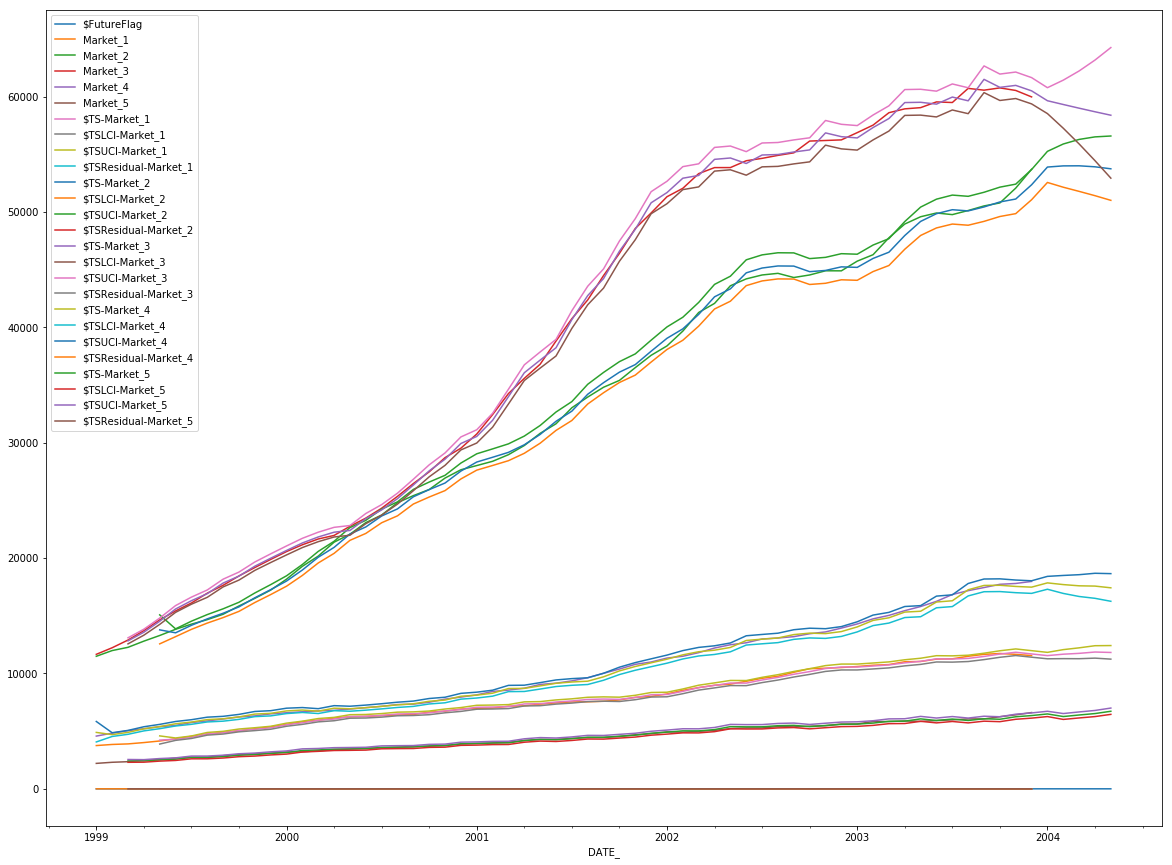

In [79]:
# Plot
dfPredict.set_index(key_ts).plot(figsize=(20,15));

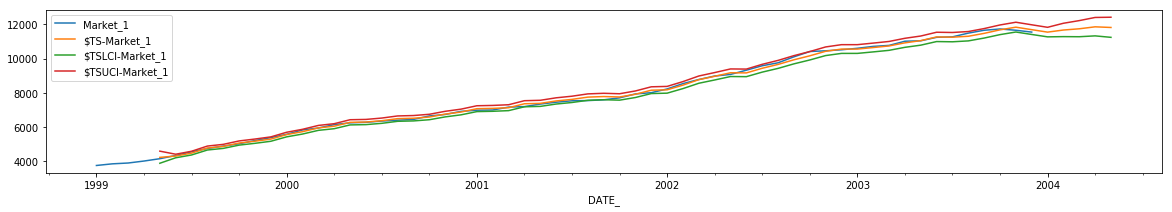

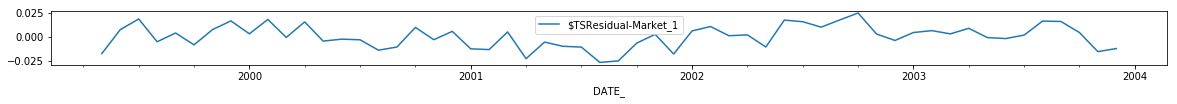

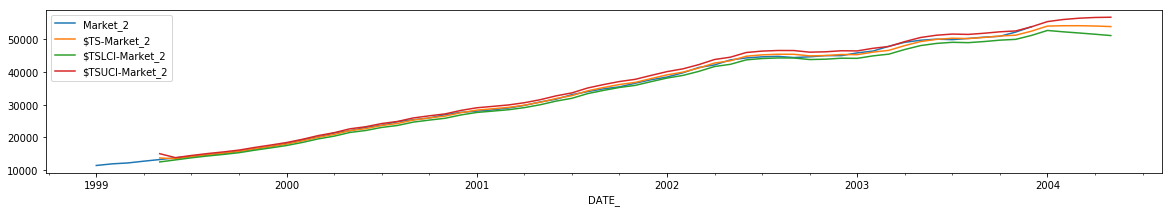

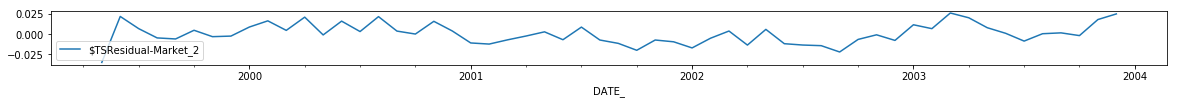

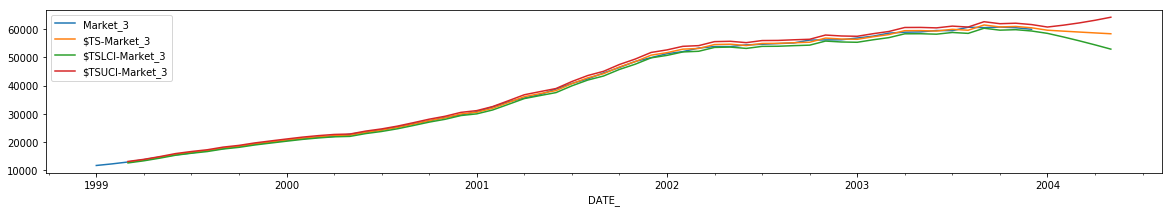

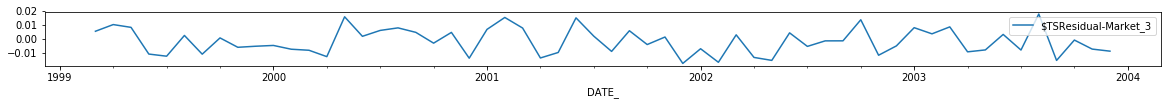

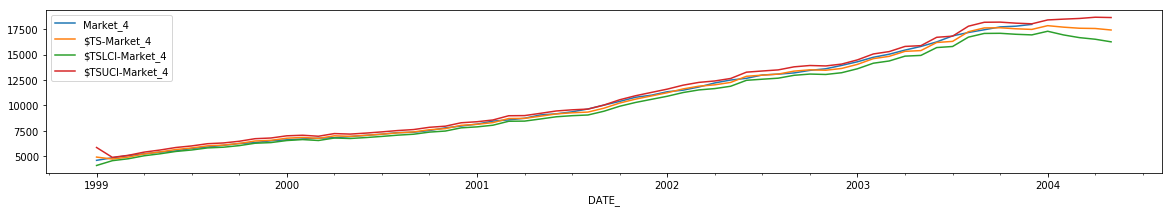

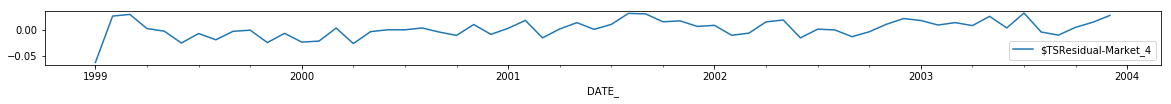

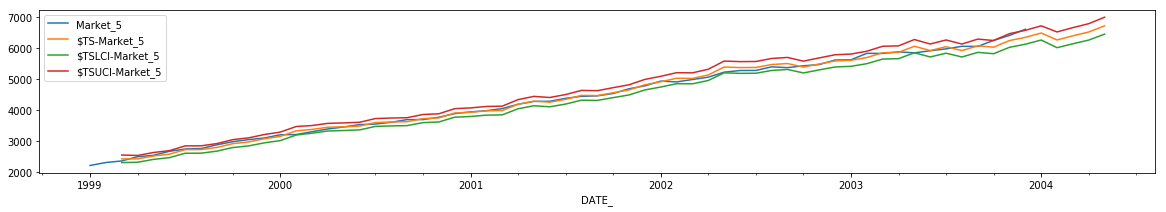

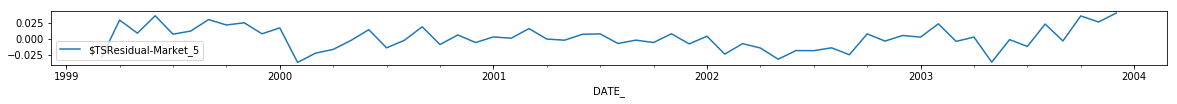

In [119]:
# plot each market
marketNum=4
for marketNum in range(1,6):
    marketCols=[key_ts]
    [marketCols.append(x) for x in dfPredict.columns if x.endswith('Market_{}'.format(marketNum)) and x.find("Residual")==-1]
    dfPredict[marketCols].set_index(key_ts).plot(figsize=(20,3));
    dfPredict[[key_ts,'$TSResidual-Market_{}'.format(marketNum)]].set_index(key_ts).plot(figsize=(20,1));

In [18]:
# Write out the CSV data to a file object in COS
import io
cos.upload_fileobj(io.BytesIO(dfPredict.to_csv(encoding='utf-8').encode('utf-8')),cos_credentials['BUCKET'],"predicted_{}".format(cos_credentials['FILE']))